<a href="https://colab.research.google.com/github/Fovay/Project1/blob/main/%22%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%822_FastAPI%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
from numpy import array
import pandas as pd
import cv2
from glob import glob
import PIL
import time
from tqdm import tqdm
import os

Подсчитываем общее количество изображений в формате .jpg в нашем каталоге изображений.

In [3]:
image_path = "/content/drive/MyDrive/Colab Notebooks/Img/Images/"
images = glob(image_path + "*.jpg")
len(images)

8091

В следующем блоке мы визуализируем небольшую выборку данных (около пяти изображений), чтобы получить представление о типе изображений, с которыми мы имеем дело в этом наборе данных.

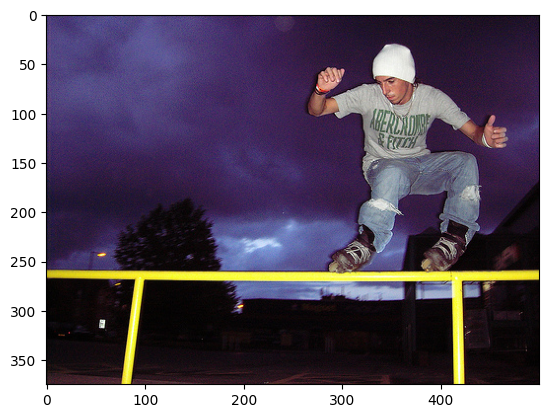

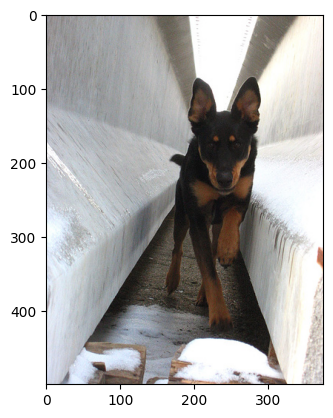

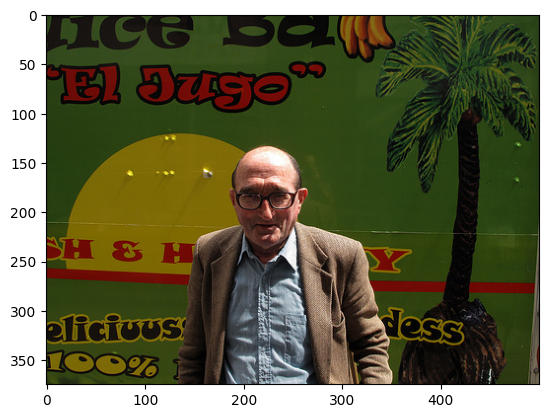

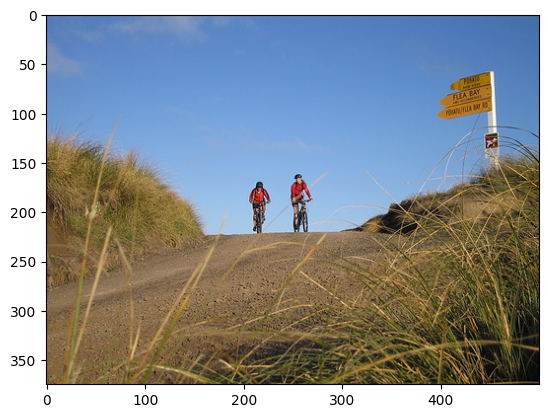

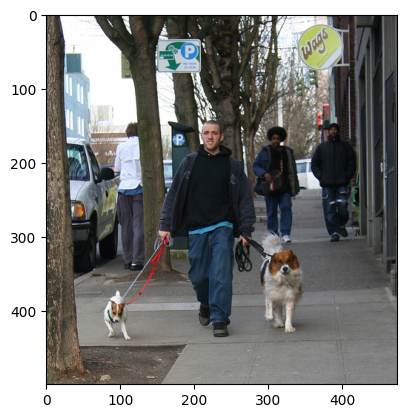

In [4]:
for i in range(5):
    plt.figure()
    image = cv2.imread(images[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

Создадим функцию для загрузки соответствующих файлов и последующего их просмотра.

In [5]:
def load(filename):
    file = open("/content/drive/MyDrive/Colab Notebooks/Img/captions.txt", 'r')
    text = file.read()
    file.close()
    return text

file = "captions.txt"
info = load(file)
print(info[:484])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting



Переименовываем файл в captions1.txt.

In [6]:
file = "captions1.txt"
info = load(file)
print(info[:470])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog


Создадим функцию для создания словаря изображений и соответствующих им подписей.

In [7]:
def load_captions(info):
    dict_1 = dict()
    count = 0
    for line in info.split('\n'):
        splitter = line.split('.jpg,')
        if len(splitter) == 2:  # Проверка, что строка содержит '.jpg,'
            image_code, image_caption = splitter[0], splitter[1]
            if image_code not in dict_1:
                dict_1[image_code] = list()
            dict_1[image_code].append(image_caption)

    return dict_1
data = load_captions(info)
print(len(data))


8091


Смотрим ключи и значения словаря

In [8]:
list(data.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [9]:
data['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

Очистка и предварительная обработка данных

In [10]:
def cleanse_data(data):
    dict_2 = dict()
    for key, value in data.items():
        for i in range(len(value)):
            lines = ""
            line1 = value[i]
            for j in line1.split():
                if len(j) < 2:
                    continue
                j = j.lower()
                lines += j + " "
            if key not in dict_2:
                dict_2[key] = list()

            dict_2[key].append(lines)

    return dict_2

data2 = cleanse_data(data)
print(len(data2))

8091


Преобразуем следующее в словарь и подсчитываем общее количество слов

In [11]:
def vocabulary(data2):
    all_desc = set()
    for key in data2.keys():
        [all_desc.update(d.split()) for d in data2[key]]
    return all_desc

vocabulary_data = vocabulary(data2)
print(len(vocabulary_data))

9148


Сохраняем описания в файл, по одной в строку

In [12]:
def save_dict(data2, filename):
    lines = list()
    for key, value in data2.items():
        for desc in value:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_dict(data2, 'captions1.txt')

Мы воспользуемся функцией предварительной обработки и загрузим пути к каждому изображению.

In [13]:
images = '/content/drive/MyDrive/Colab Notebooks/Img/Images/'
img = glob(images + '*.jpg')
print(len(img))

def preprocess(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    x = keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = keras.applications.inception_v3.preprocess_input(x)
    return x

8091


Загружаем начальную модель. И создаем новую модель, удалив последний слой (выходной слой) из начальной версии.

In [14]:
input1 = InceptionV3(weights='imagenet')

model = Model(input1.input, input1.layers[-2].output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

После вычисления предварительной обработки изображений сохраняем все значения в файле Pickle.

In [15]:
#def encode(image):
    #image = preprocess(image)
    #fea_vec = model.predict(image)
    #fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    #return fea_vec

#encoding = {}

#for i in tqdm(img):
    #encoding[i[len(images):]] = encode(i)
import pickle

with open('/content/drive/MyDrive/Colab Notebooks/Img/images1.pkl', 'rb') as f:
    encoding = pickle.load(f)


Сохраняем все необходимые файлы, содержащие информацию об уникальных словах для индексирования, а также все индексы, связанные с соответствующими словами. Определим фиксированную максимальную длину для этой операции, чтобы она не превышала установленные нами ограничения.

In [16]:
all_train_captions = []

for key, val in data2.items():
    for cap in val:
        all_train_captions.append(cap)

len(all_train_captions)

word_count_threshold = 10
word_counts = {}
nsents = 0

for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1
vocab_size


with open("words.pkl", "wb") as encoded_pickle:
    pickle.dump(wordtoix, encoded_pickle)

with open("words1.pkl", "wb") as encoded_pickle:
    pickle.dump(ixtoword, encoded_pickle)


def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

max_length = max_length(data2)
print('Description Length: %d' % max_length)

preprocessed words 9149 -> 1975
Description Length: 33


Создаем генератор данных, который будет загружать всю информацию о векторах изображений, соответствующие описания модели, максимальную длину, фиксированные слова для индексных значений, количество шагов, выполняемых за эпоху, и все другие элементарные действия.

In [17]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key+'.jpg']
            for desc in desc_list:
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

Переходим к заключительному этапу построения архитектуры модели для выполнения задачи создания подписей к изображениям.

Создаем векторы встраивания слов для каждого уникального слова фиксированной длины.

In [18]:
embeddings_index = {}
f = open('/content/drive/MyDrive/Colab Notebooks/Img/glove.6B.200d.txt', encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

embedding_dim = 200

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_matrix.shape

Found 400001 word vectors.


(1976, 200)

В этой модели мы будем использовать два входных параметра, а именно векторы изображений и встраивания слов в подписи, для создания прогнозов.

In [19]:
from keras.layers import Dense, Input, Conv2D, MaxPool2D, LSTM, add
from keras.layers import Activation, Dropout, Flatten, Embedding

inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 33)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 33, 200)              395200    ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                            

Обучаем модель около десяти эпох из-за ограничения по времени.

In [20]:
#model.layers[2].set_weights([embedding_matrix])
#model.layers[2].trainable = False

#model.compile(loss='categorical_crossentropy', optimizer='adam')

#epochs = 3
#number_pics_per_bath = 3
#steps = len(data2)//number_pics_per_bath

#features = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Img/images1.pkl", "rb"))

#tf.data.experimental.enable_debug_mode()

#for i in range(epochs):
    #generator = data_generator(data2, features, wordtoix, max_length, number_pics_per_bath)
    #model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('my_model.keras')

Загружаем все сохраненные файлы в соответствующие переменные.

In [21]:
from keras.models import load_model

features = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Img/images1.pkl", "rb"))
model = load_model('my_model.keras')
images = "/content/drive/MyDrive/Colab Notebooks/Img/Images/"
max_length = 33
words_to_index = pickle.load(open("words.pkl", "rb"))
index_to_words = pickle.load(open("words1.pkl", "rb"))

Определим соответствующую функцию, которая будет принимать изображения, загружать их векторы, создавать встраивание слов и использовать сохраненную модель для создания соответствующих прогнозов.

In [22]:
def Image_Caption(picture):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [words_to_index[w] for w in in_text.split() if w in words_to_index]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([picture,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_words[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

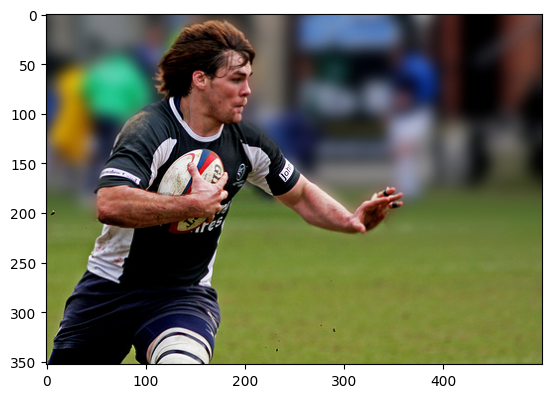

Caption: men are playing


In [23]:
z = 1011
pic = list(features.keys())[z]
image = features[pic].reshape((1,2048))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", Image_Caption(image))

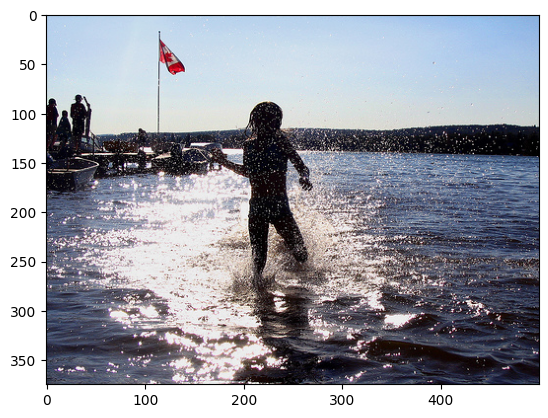

Caption: man is walking on the beach with his arms


In [24]:
z = 499
pic = list(features.keys())[z]
image = features[pic].reshape((1,2048))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", Image_Caption(image))

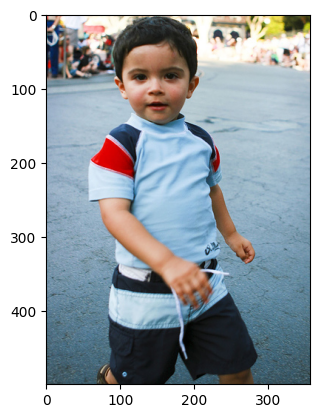

Caption: little boy in red shirt is playing with


In [25]:
z = 777
pic = list(features.keys())[z]
image = features[pic].reshape((1,2048))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", Image_Caption(image))

Public URL: https://9aa4-34-75-101-177.ngrok-free.app


INFO:     Started server process [177357]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     62.78.87.46:0 - "GET / HTTP/1.1" 404 Not Found
INFO:     62.78.87.46:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found


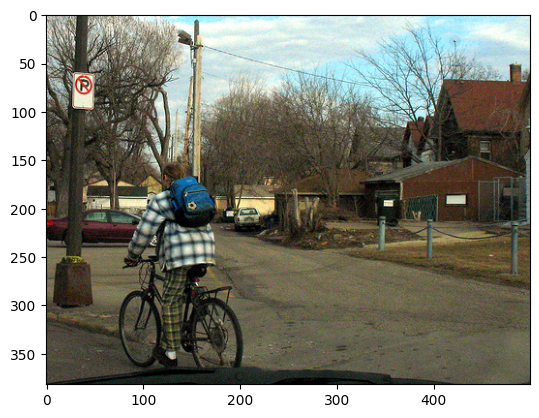

INFO:     62.78.87.46:0 - "GET /predict_caption HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [177357]


KeyboardInterrupt: 

In [27]:
from fastapi import FastAPI
import matplotlib.pyplot as plt
import numpy as np
import os
import nest_asyncio
from pyngrok import ngrok

app = FastAPI()

@app.get("/predict_caption")
async def predict_caption():
    z = 201
    pic = list(features.keys())[z]
    image = features[pic].reshape((1, 2048))
    x = plt.imread(images + pic)
    plt.imshow(x)
    plt.show()
    caption = Image_Caption(image)
    return {"image_caption": caption}

if __name__ == "__main__":
    import uvicorn
    ngrok.set_auth_token("2hMWXqPXFps8J9KJ661ZKCfLKlR_4iXeEPxWgKL9an7xLrVdE")
    ngrok_tunnel = ngrok.connect(8000)
    print('Public URL:', ngrok_tunnel.public_url)
    nest_asyncio.apply()
    uvicorn.run(app, port=8000)

In [ ]:
#model.save('my_model.keras')

Производительность модели создания подписей к изображениям хорошая. Однако, из-за небольшого размера набора данных для обучения, модель не совсем точно создает подписи к некоторым изображениям. Для того чтобы в дальнейшем увеличить точность модели необходимо будет обучить модель на большем наборе данных и количестве эпох.